# Forecasting Vaccination Trends with Time Series Models

In this notebook, I am going to import all of the vaccine data gathered from the four most populous US cities, in the timeframe of 1/1/21-6/15/21. The vaccination data was pulled from each respective city's health department, so all files are slightly different in the information they're supplying. The first part of the notebook focuses on cleaning and inspecting the data before moving on to time series analysis.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

import numpy as np

#data exploration
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose


#modeling
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

#evaluation metrics
import scipy.stats as stats
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing all files
nyc = pd.read_csv('data/nyc.csv')
houston = pd.read_csv('data/Houston.csv')
la = pd.read_csv('data/la.csv')
chicago = pd.read_csv('data/chicago.csv')

## Data Cleaning

After importing all packages and files, I am going through to make sure each has a consistent format including date range and column name for the target variable. I also am labeling each city within the dataframe for when I merge them. 

In [3]:
# starting with new york

# adding location column
nyc['city'] = 'new york'  

# converting dates to datetime
nyc['date'] = pd.to_datetime(nyc['DATE'])  

# filtering to consistent timeframe
new_nyc = nyc[nyc['date'] >= '2021-01-01'] 

# getting consistent column name for vaccines administered
new_nyc['total_doses'] = new_nyc['ADMIN_ALLDOSES_DAILY']

In [4]:
# repeating steps with houston

houston['date'] = pd.to_datetime(houston['Date_str'])

new_houston = houston[(houston['date'] >= '2021-01-01')
                      & (houston['date'] <= '2021-06-15')]

new_houston['total_doses'] = new_houston['Vaccinated']

# need to do a groupby since there are multiple readings from each date
new_houston = new_houston.groupby(['date'], as_index=False).sum()
new_houston['city'] = 'houston'  # adding location column after groupby

In [5]:
#also need to difference the data as it is cumulative
new_houston['total_doses'] = new_houston['total_doses'].diff()

In [6]:
#chicago
chicago['city'] = 'chicago'
chicago['date'] = pd.to_datetime(chicago['Date'])
chicago['total_doses'] = chicago['Total Doses - Daily']
new_chicago = chicago[chicago['date'] >= '2021-01-01']

In [7]:
#los angeles, also need to group by date
la['date'] = pd.to_datetime(la['Date (Dose 1)'])
new_la = la[la['date'] >= '2021-01-01']
new_la = new_la.groupby(['date'], as_index=False).sum()
new_la['city'] = 'los angeles'
new_la['total_doses'] = new_la['Dose1_all']

I'm writing a function to run each dataframe through to format with only the columns I want. Then I'll look at the data overall.

In [8]:
def to_merge(dataframe):
    
    """preps dataframe for time series formatting"""
    
    city_subset = dataframe[['date', 'city', 'total_doses']]
    return(city_subset)

In [9]:
nyc_merge = to_merge(new_nyc)
houston_merge = to_merge(new_houston)
chicago_merge = to_merge(new_chicago)
la_merge  = to_merge(new_la)

In [10]:
#combining dataframes
combined = pd.concat([nyc_merge, houston_merge, chicago_merge, la_merge],
                     ignore_index=True, sort=False).sort_values(by='date')

time_indexed_combined = combined.set_index('date')

time_indexed_combined.head()

,city,total_doses
date,,
2021-01-01,new york,167.0
2021-01-01,houston,NaN
2021-01-01,los angeles,1112.0
2021-01-01,chicago,48.0
2021-01-02,houston,2737.0


It looks like the overall trend is that the # vaccines per day peaked in April, when most places started making the vaccine available to more of the population. After that, the decline is pretty sharp. In the next section we'll see how this differs (or not) by location)

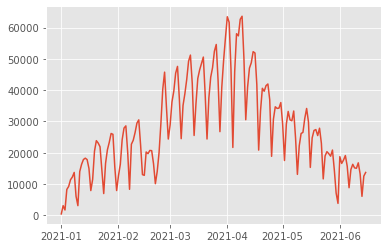

In [11]:
ti_mean = time_indexed_combined.groupby('date').mean()
plt.plot(ti_mean)

## Creating Time Series 

Now that I've cleaned and inspected the data, I'm going to format each city's dataframe for time series modeling.

Looking at the chart below, I can get an idea of how the volume of vaccinations differ from place to place, where New York City is seeing a much higher volume than Houston overall. 

In [12]:
#formatting for time series model
nyc_ts = nyc_merge.set_index('date')['total_doses']
hou_ts = houston_merge.set_index('date')['total_doses']
chi_ts = chicago_merge.set_index('date')['total_doses']
la_ts = la_merge.set_index('date')['total_doses']

In [13]:
#due to the groupby there is 1 null in the houston data
hou_ts = hou_ts.dropna()

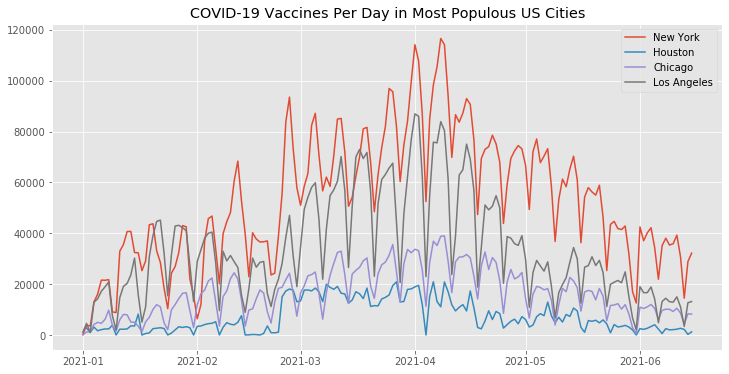

In [14]:
fig = plt.figure(figsize=(12,6))
plt.plot(nyc_ts, label='New York')
plt.plot(hou_ts, label='Houston')
plt.plot(chi_ts, label='Chicago')
plt.plot(la_ts, label='Los Angeles')
plt.title("COVID-19 Vaccines Per Day in Most Populous US Cities")
plt.legend()
# plt.savefig('Images/vaccines_per_day.png')

## Checking for Trends

In each city there appear to be periodic trends, which would violate the assumption of stationarity that I'd need for a time series model to be effective. Below I am going to run a test to check if my data is stationary.

The function below will compare the rolling mean and standard deviation of each city for a visual of the trends, as well as run the Dickey-Fuller test. If the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary.

In [15]:
def stationarity_plot(data, city):
    
    """
    Calcuates and plots rolling mean and rolling standard deviation
    for each time series against the original data and outputs 
    results from Dickey-Fuller test to assess stationarity. 
    
    """
    
    roll_mean = data.rolling(window=7, center=False).mean()
    roll_std = data.rolling(window=7, center=False).std()
    
    dftest = adfuller(data)

    fig = plt.figure(figsize=(12,6))
    plt.plot(data, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(city))
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test for {}: \n'.format(city))

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

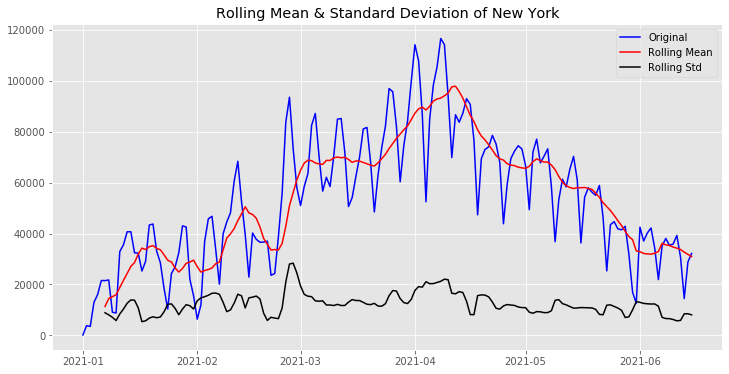

Results of Dickey-Fuller Test for New York: 

Test Statistic                  -1.198953
p-value                          0.674046
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


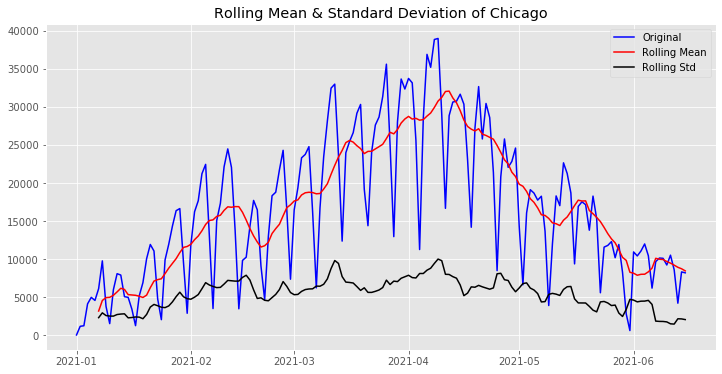

Results of Dickey-Fuller Test for Chicago: 

Test Statistic                  -1.712065
p-value                          0.424907
#Lags Used                      14.000000
Number of Observations Used    151.000000
Critical Value (1%)             -3.474416
Critical Value (5%)             -2.880878
Critical Value (10%)            -2.577081
dtype: float64


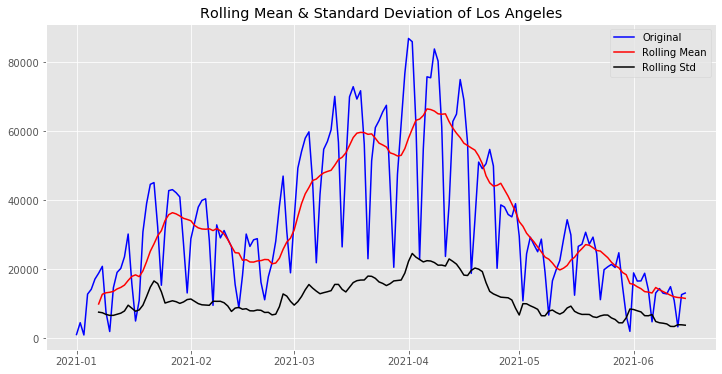

Results of Dickey-Fuller Test for Los Angeles: 

Test Statistic                  -1.547956
p-value                          0.509669
#Lags Used                       8.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


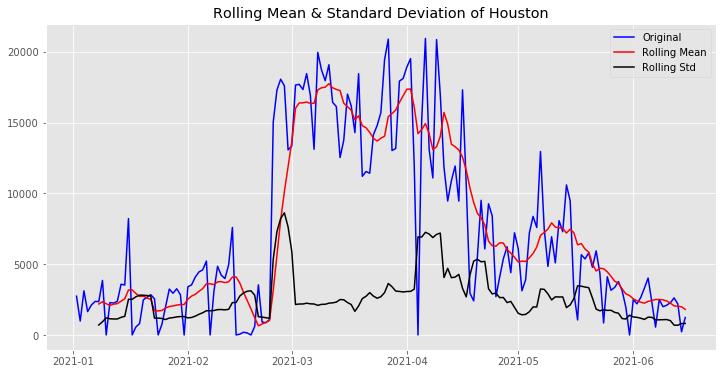

Results of Dickey-Fuller Test for Houston: 

Test Statistic                  -1.540347
p-value                          0.513466
#Lags Used                       7.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In [16]:
stationarity_plot(nyc_ts, 'New York')
stationarity_plot(chi_ts, 'Chicago')
stationarity_plot(la_ts, 'Los Angeles')
stationarity_plot(hou_ts, 'Houston')

Results uphold the null hypothesis: the time series is not stationary for any of the cities. So I need to look into removing trends.

To get a deeper understanding of the underlying trends, I'm going to use statsmodels's decomposition tool and run each of my cities' data throuugh a function that visualizes it. 

## Decomposition

In [17]:
def decompose(ts):
    
    """
    plots statsmodels's seasonal decomposition charts
    to visualize underlying trends in data
    """
    
    decomposition = seasonal_decompose((ts))

    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

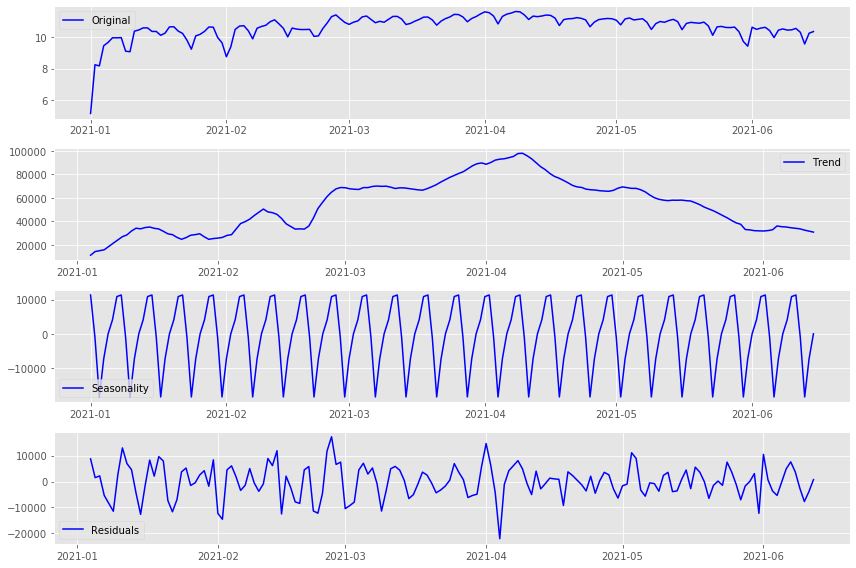

In [18]:
decompose(nyc_ts)

With each time series, there is a trend that increases and levels off in different ways. There is clear seasonality which may have to do with the majority of people receiving their vaccines on weekends. I'll need to remove the seasonality to make sure the time series are stationary. 

To do this, I am going to first log transform each to make the time series more uniform over time. Then, I'll take the rolling mean of each and subtract it from the log transformed time series.

In [19]:
# def detrend(ts):
#     ts_log = np.log(ts)
#     roll_mean = ts_log.rolling(window=7).mean()

#     # Subtract the moving average from the log transformed data
#     data_minus_roll_mean = ts_log - roll_mean

#     # Print the first 10 rows
#     data_minus_roll_mean.dropna(inplace=True)
    
#     fig = plt.figure(figsize=(11,7))
#     plt.plot(data_minus_roll_mean)
#     plt.title('Vaccines with rolling mean subtracted')
#     plt.show(block=False)

In [20]:
# nyc_detrended = detrend(nyc_ts)
# hou_detrended = detrend(hou_ts)
# chi_detrended = detrend(chi_ts)
# la_detrended = detrend(la_ts)

This already looks better so I'm going to check again for stationarity.


It looks like the NYC data has just made it.

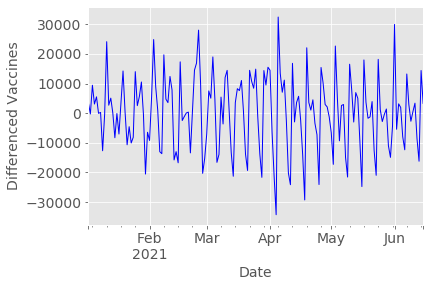

In [21]:
## Differencing
nyc_diff = nyc_ts.diff()
nyc_diff.dropna(inplace=True)
nyc_diff.plot(color='blue', linewidth=1, fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Vaccines', fontsize=14);

## Checking Correlations

I am also going to take a look at correlations in my data over time to see 

In [22]:
def correlation_plots(df):
    
    """outputs statsmodels's correlation and auto correlation plots"""
    
    rcParams['figure.figsize'] = 14, 5
    plot_acf(df, lags=50);

    rcParams['figure.figsize'] = 14, 5
    plot_pacf(df, lags=50);

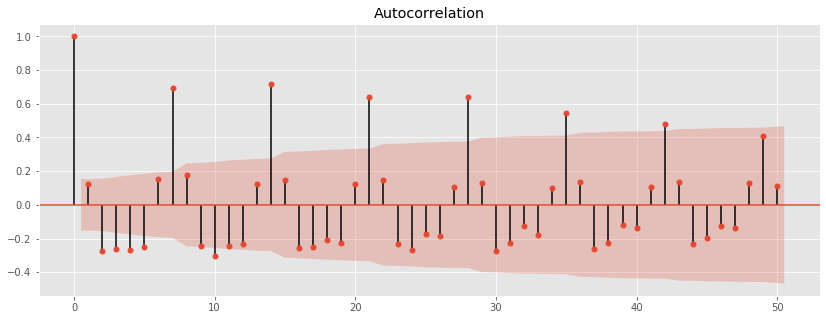

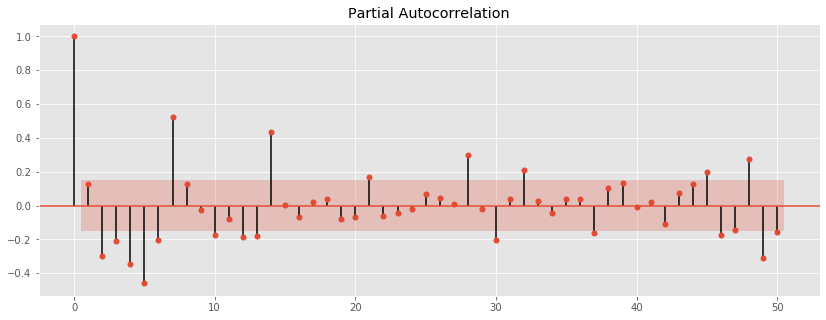

In [23]:
correlation_plots(nyc_diff)

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

## Time Series Modeling

### NYC

Now that I have a thorough understanding of my data, I can start the modeling process. I'm first going to establish an 80/20 train test split.

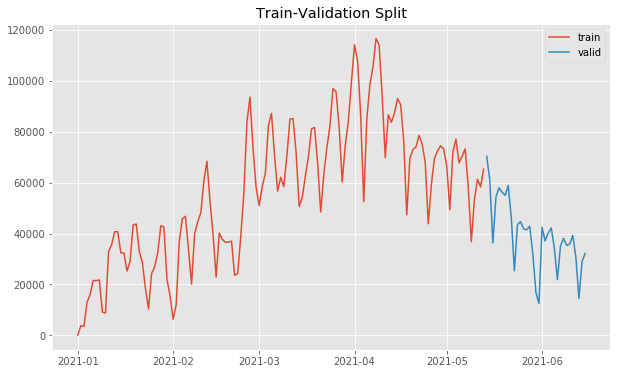

In [110]:
# Define train and test sets according to the index found above

cutoff = 133 #80% of data

nyc_train = nyc_ts[:cutoff]
nyc_test = nyc_ts[cutoff:]

#visualize split
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(nyc_train, label='train')
ax.plot(nyc_test, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()
    

For my modeling method, I'm going to use auto arima which will do an automated grid search that selects my pdq terms based on the best AIC score.

Starting with New York, I'm going to build a model and then run it through an evaluation function

In [111]:
auto_arima_nyc = pm.auto_arima(nyc_train, start_p=0, start_d=0, start_q=0, 
                      max_p=5, max_d=5, max_q=5, start_P=0, 
                      D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, 
                      m=12, seasonal=False, error_action='warn', 
                      trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2872.980, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2870.878, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2868.028, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2871.183, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2866.871, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2840.219, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2861.048, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2838.630, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2855.338, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2827.513, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2836.866, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2818.566, Time=0.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2817.519, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2816.904, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]          

In [116]:
#default seasonal order is (0,0,0,0)
arima_nyc = sm.tsa.statespace.SARIMAX(nyc_train, 
                                        order=(5, 1, 0),
                                        seasonal_order=(0,0,0,0),
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = arima_nyc.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0787      0.079     -0.993      0.321      -0.234       0.077
ar.L2         -0.4006      0.106     -3.794      0.000      -0.608      -0.194
ar.L3         -0.3020      0.105     -2.876      0.004      -0.508      -0.096
ar.L4         -0.3484      0.111     -3.143      0.002      -0.566      -0.131
ar.L5         -0.3839      0.107     -3.585      0.000      -0.594      -0.174
sigma2      1.002e+08   3.19e-10   3.14e+17      0.000       1e+08       1e+08


In [117]:
pred = output.get_prediction(start=pd.to_datetime('2021-06-01'), dynamic=False)
pred_conf = pred.conf_int()

pred_dynamic = output.get_prediction(start=pd.to_datetime('2021-06-16'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [118]:
forecasted = pred.predicted_mean
truth = nyc_ts

# Compute the mean square error
rmse = np.sqrt(((forecasted - truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 38372.02


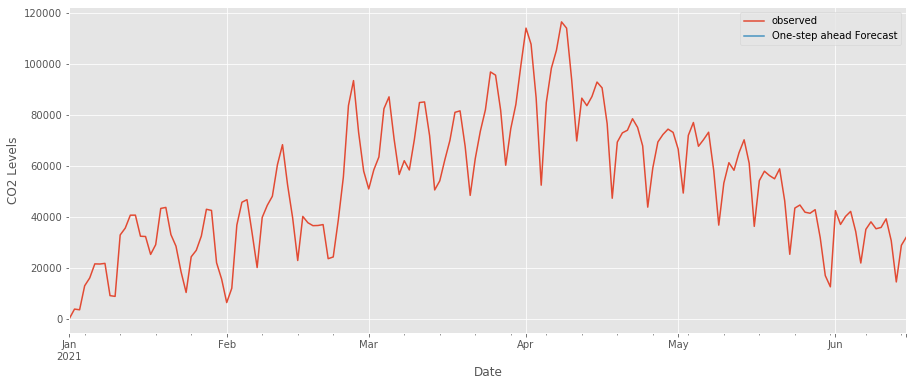

In [119]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nyc_ts.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

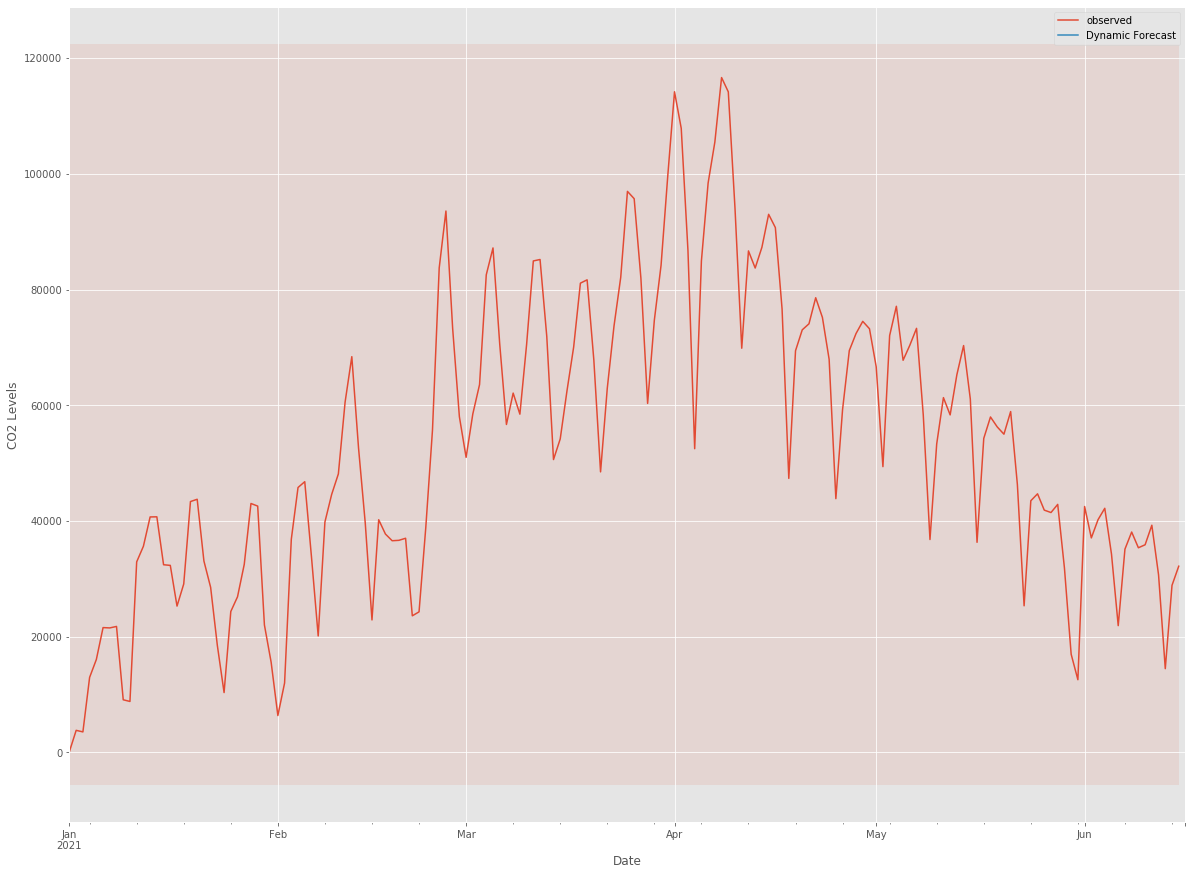

In [81]:
# Plot the dynamic forecast with confidence intervals.

ax = nyc_ts.plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-01-01'), nyc_ts.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [82]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

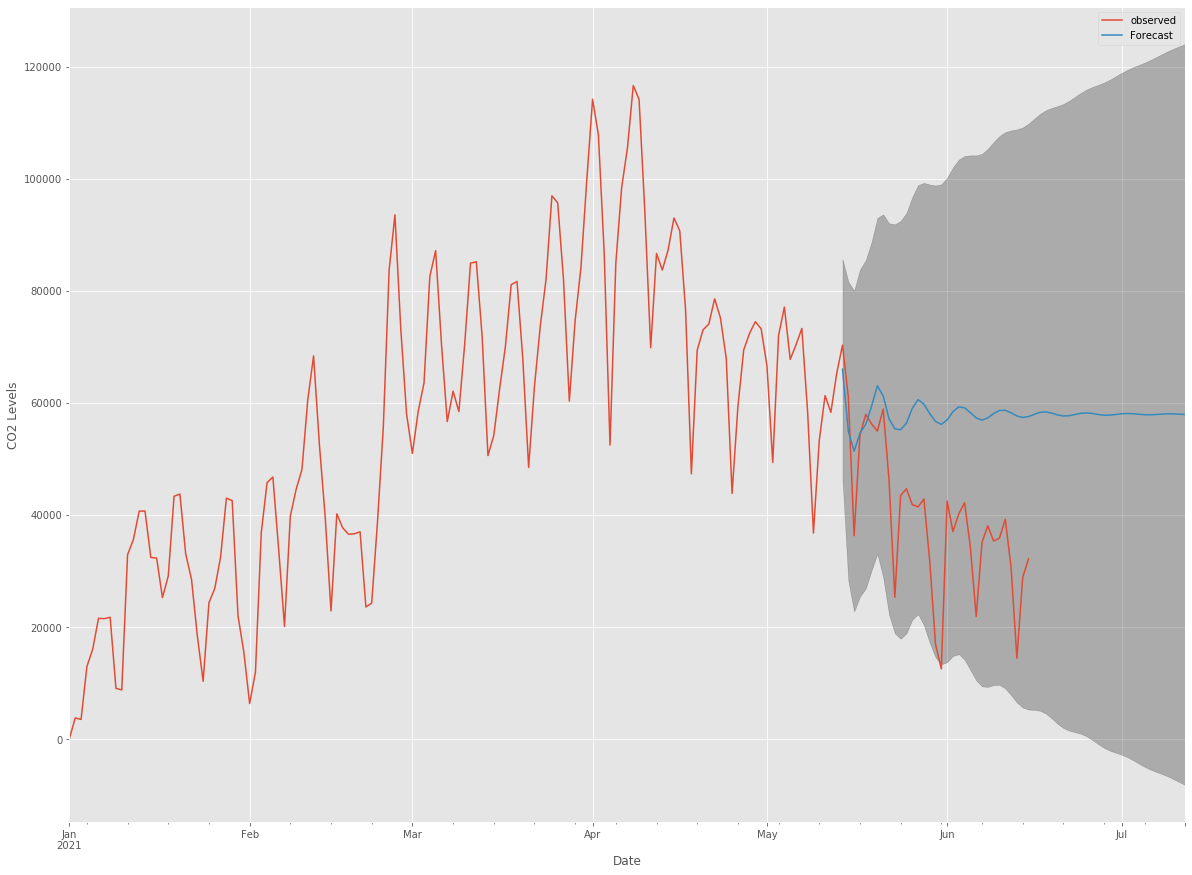

In [83]:
ax = nyc_ts.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [84]:
# d=1 since data is not stationary

# def eval_arima(model, train, test, city):
    
#     """
#     taking in fitted arima model and train/test data, 
#     makes predicitons and plots against actuals;
#     calculates and prints RMSE
#     """
  
#     #make predictions
#     forecast = model.predict(n_periods=len(test))
#     forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#     rmse = sqrt(mean_squared_error(test,forecast))
    
#     #plot the predictions for validation set
#     plt.plot(train, label='Train')
#     plt.plot(test, label='Test')
#     plt.plot(forecast, label='Prediction')
#     plt.title(f'Arima Model Forecast for {city} with a RMSE of {round(rmse, 2)}')
#     plt.show()


In [85]:
eval_nyc = eval_arima(arima_nyc, nyc_train, nyc_test, 'New York')


TypeError: predict() missing 1 required positional argument: 'params'

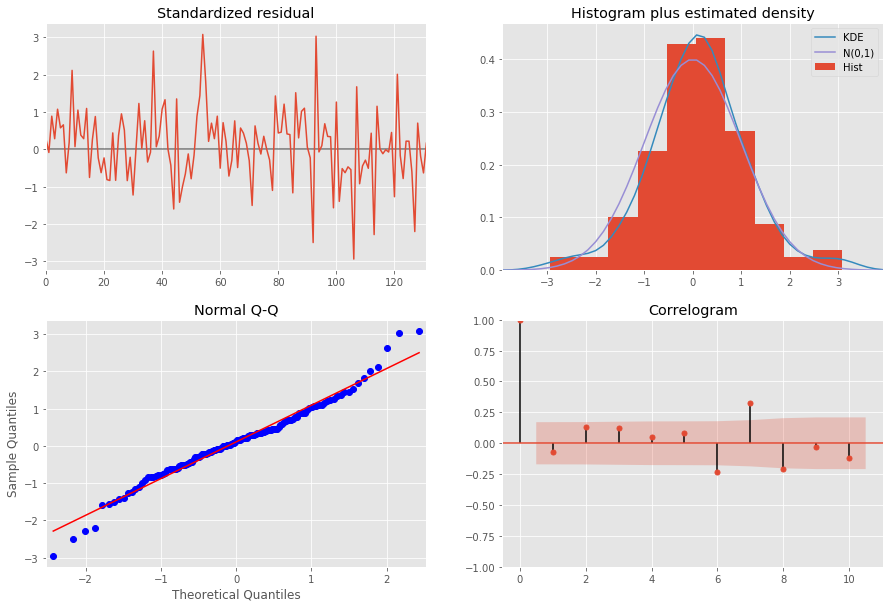

In [28]:
arima_nyc.plot_diagnostics(figsize=(15, 10))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

### Chicago

In [29]:
chi_train = chi_ts[:cutoff]
chi_test = chi_ts[cutoff:]

In [30]:
arima_chi = pm.auto_arima(chi_train, start_p=0, d=1, start_q=0, 
                      max_p=5, max_d=5, max_q=5, start_P=0, 
                      D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, 
                      m=12, seasonal=False, error_action='warn', 
                      trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2692.518, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2694.219, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2693.023, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2690.616, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2683.301, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2651.411, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2670.614, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2653.321, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2630.040, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2651.414, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2653.691, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2626.344, Time=0.72 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2

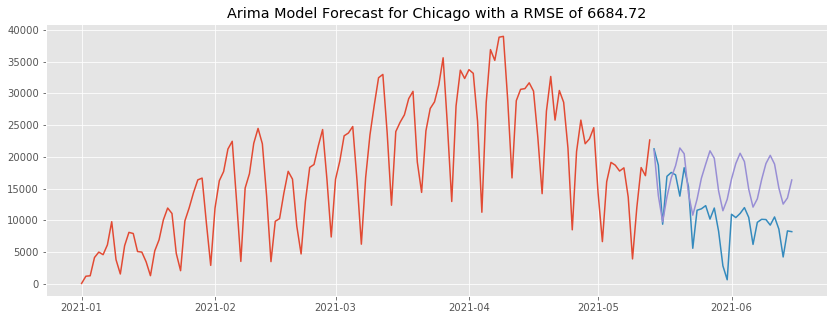

In [31]:
eval_chi = eval_arima(arima_chi, chi_train, chi_test, 'Chicago')

My error is much lower for the Chicago model, likely because the trend isn't as drastic as New York. I can see however that it is not picking up on the downward spikes that happen at the end of the timeframe, likely because there is not enough training data to capture the full picture.

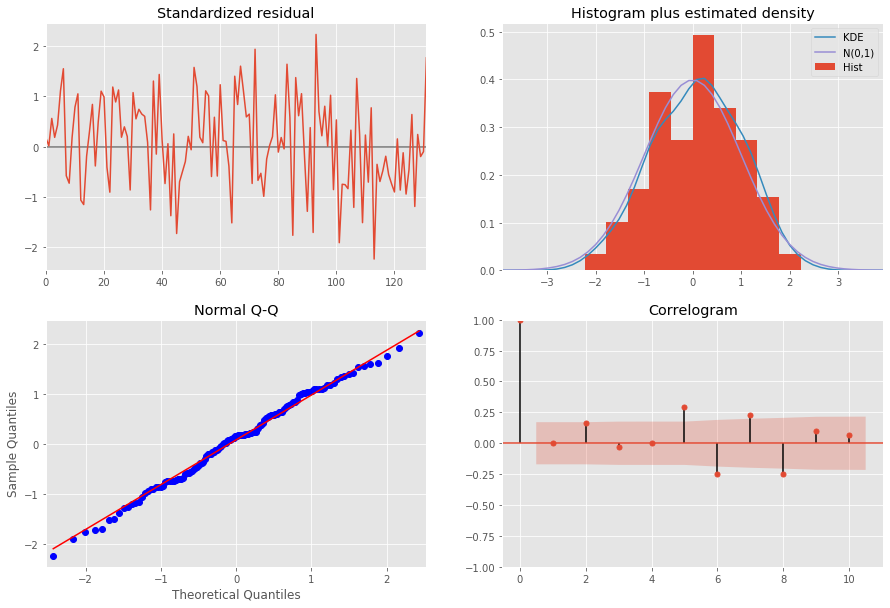

In [32]:
arima_chi.plot_diagnostics(figsize=(15, 10))
plt.show()

### Houston

In [33]:
hou_train = hou_ts[:cutoff]
hou_test = hou_ts[cutoff:]

In [34]:
arima_hou = pm.auto_arima(hou_train, start_p=0, d=1, start_q=0, 
                      max_p=5, max_d=5, max_q=5, start_P=0, 
                      D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, 
                      m=12, seasonal=False, error_action='warn', 
                      trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2551.640, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2550.391, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2542.073, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2549.677, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2536.108, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2530.364, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2532.938, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2532.086, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2531.815, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2530.443, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2533.077, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2528.416, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2533.760, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

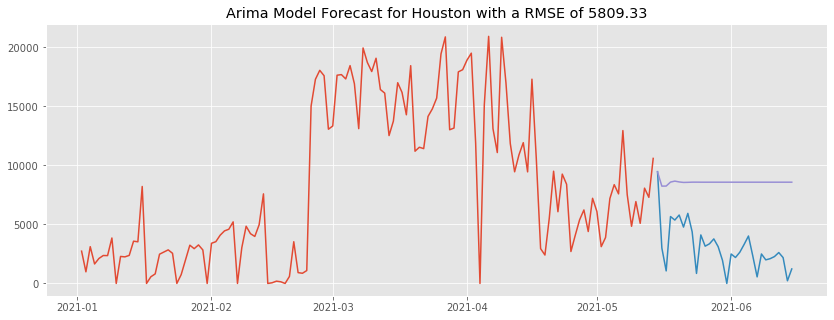

In [35]:
eval_hou = eval_arima(arima_hou, hou_train, hou_test, 'Houston')

The Houston model is having a hard time picking up seasonality, but the overall RMSE is actually the lowest so far. 

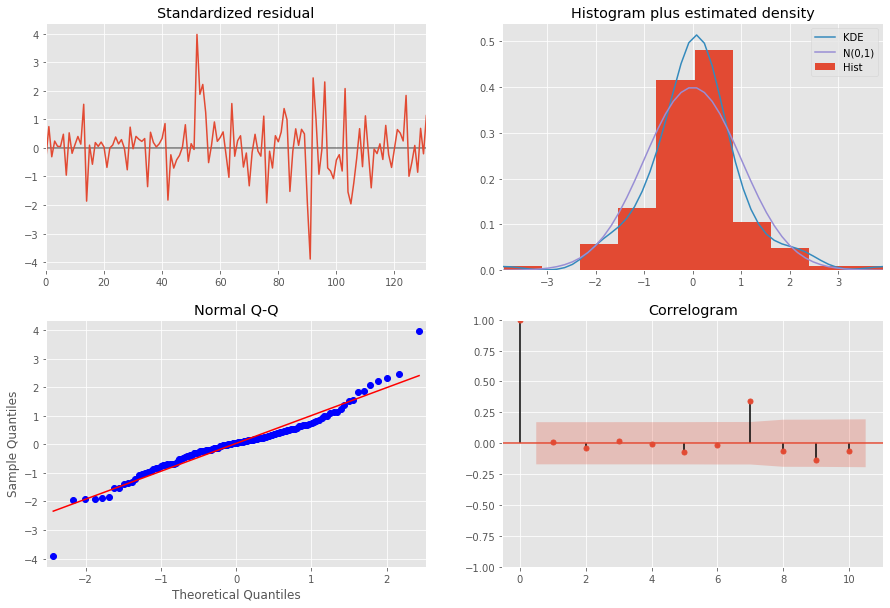

In [36]:
arima_hou.plot_diagnostics(figsize=(15, 10))
plt.show()

### Los Angeles

In [37]:
la_train = la_ts[:cutoff]
la_test = la_ts[cutoff:]

In [38]:
arima_la = pm.auto_arima(la_train, start_p=0, d=1, start_q=0, 
                      max_p=5, max_d=5, max_q=5, start_P=0, 
                      D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, 
                      m=12, seasonal=False, error_action='warn', 
                      trace=True, stepwise=True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2893.520, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2894.576, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2892.743, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2891.555, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2885.657, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2856.472, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2876.968, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2857.761, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2877.449, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2876.944, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2875.436, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2854.551, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2883.669, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : 

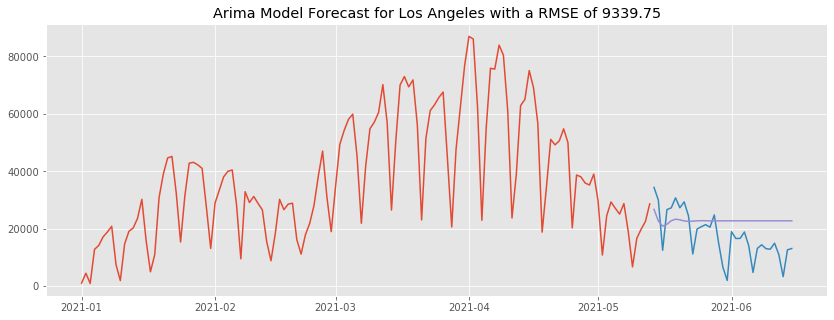

In [39]:
eval_la = eval_arima(arima_la, la_train, la_test, 'Los Angeles')

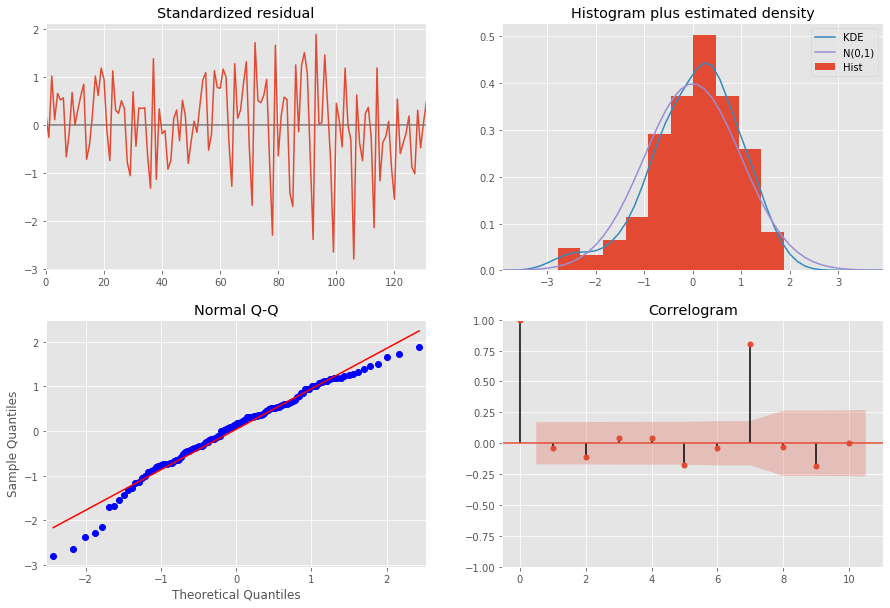

In [40]:
arima_la.plot_diagnostics(figsize=(15, 10))
plt.show()

## Forecasting

In [41]:
# pred = arima_nyc.predict(start=pd.to_datetime('2021-06-15'), dynamic=False)

In [42]:
# from pmdarima.metrics import smape

# model = arima_nyc  # seeded from the model we've already fit

# def forecast_one_step():
#     fc, conf_int = model.predict(n_periods=100, return_conf_int=True)
#     return (
#         fc.tolist()[0],
#         np.asarray(conf_int).tolist()[0])

# forecasts = []
# confidence_intervals = []

# for new_ob in valid:
#     fc, conf = forecast_one_step()
#     forecasts.append(fc)
#     confidence_intervals.append(conf)

#     # Updates the existing model with a small number of MLE steps
#     model.update(new_ob)

# print(f"Mean squared error: {mean_squared_error(valid, forecasts)}")
# print(f"SMAPE: {smape(valid, forecasts)}")


In [43]:
# fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# # --------------------- Actual vs. Predicted --------------------------
# axes[0].plot(train, color='blue', label='Training Data')
# axes[0].plot(valid.index, forecasts, color='green', marker='o',
#              label='Predicted Price')

# axes[0].plot(valid.index, valid, color='red', label='Actual Price')
# axes[0].set_title('Microsoft Prices Prediction')
# axes[0].set_xlabel('Dates')
# axes[0].set_ylabel('Prices')

# # axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
# # axes[0].legend()


# # ------------------ Predicted with confidence intervals ----------------
# axes[1].plot(train, color='blue', label='Training Data')
# axes[1].plot(valid.index, forecasts, color='green',
#              label='Predicted Price')

# axes[1].set_title('Prices Predictions & Confidence Intervals')
# axes[1].set_xlabel('Dates')
# axes[1].set_ylabel('Prices')

# conf_int = np.asarray(confidence_intervals)
# axes[1].fill_between(valid.index,
#                      conf_int[:, 0], conf_int[:, 1],
#                      alpha=0.9, color='orange',
#                      label="Confidence Intervals")



https://alkaline-ml.com/pmdarima/usecases/stocks.html

## Correlating to Social Media Sentiment

Finally, I will import the sentiment scored time series in order to compare how each city's social media sentiment correlates to its vaccination rates over time. 

In [122]:
nyc_sent = pd.read_csv('data/nyc_sentiment.csv')
hou_sent = pd.read_csv('data/houston_sentiment.csv')
chi_sent = pd.read_csv('data/chicago_sentiment.csv')
la_sent = pd.read_csv('data/la_sentiment.csv')

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

In [123]:
nyc_corr = pd.concat([nyc_sent, nyc_ts.reset_index()['total_doses']], axis=1).set_index('date')

In [131]:
nyc_corr.dropna(inplace=True)

Scipy computed Pearson r: 0.27601154310229825 and p-value: 0.00034704952148968893


[Text(0.5, 1.0, 'Overall Pearson r For NYC Time Series= 0.27601154310229825')]

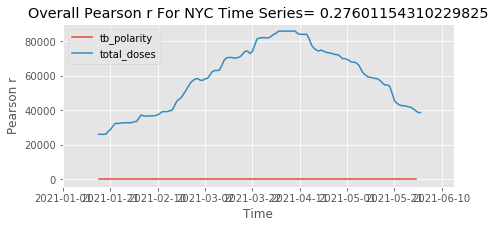

In [124]:
r, p = stats.pearsonr(nyc_corr.dropna()['tb_polarity'], nyc_corr.dropna()['total_doses'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
nyc_corr.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=("Overall Pearson r For NYC Time Series= {}").format(r))

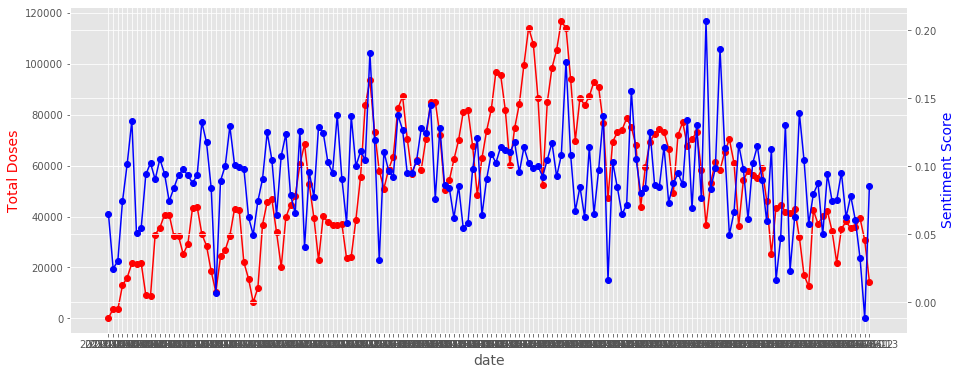

In [138]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(nyc_corr['total_doses'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("date",fontsize=14)
# set y-axis label
ax.set_ylabel("Total Doses", color="red", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(nyc_corr['tb_polarity'],color="blue",marker="o")
ax2.set_ylabel("Sentiment Score", color="blue",fontsize=14)

plt.xticks(ticks=None)
plt.show()


# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

plt.show()

Text(0.5, 0.98, 'Data and rolling window correlation')

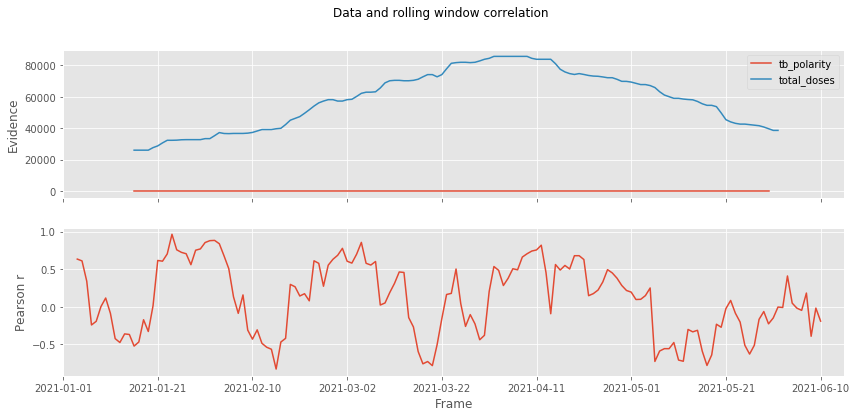

In [69]:
# Set window size to compute moving window synchrony.
r_window_size = 7

# Interpolate missing data.
# df_interpolated = df.interpolate()

# Compute rolling window synchrony
rolling_r = nyc_corr['tb_polarity'].rolling(window=r_window_size, center=True).corr(nyc_corr['total_doses'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
nyc_corr.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Data and rolling window correlation")